In [ ]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define constants and create tensors on the GPU
N_point = 22500
N_t = 77
L_left = 0
L_right = 4380
nx = ny = 150

U_total = torch.zeros((N_point * N_t, 1), dtype=torch.float32, device=device)
X_total = torch.zeros((N_point * N_t, 1), dtype=torch.float32, device=device)
Y_total = torch.zeros((N_point * N_t, 1), dtype=torch.float32, device=device)

# Populate X_total and Y_total with grid values
for i in range(N_t):
    x = np.linspace(L_left, L_right, nx)
    y = np.linspace(L_left, L_right, ny)
    X, Y = np.meshgrid(x, y)
    X_total[i * N_point : (i + 1) * N_point] = torch.tensor(X.reshape(N_point, 1), dtype=torch.float32, device=device)
    Y_total[i * N_point : (i + 1) * N_point] = torch.tensor(Y.reshape(N_point, 1), dtype=torch.float32, device=device)

# Load and preprocess U_total from the .mat file
U = sio.loadmat('U_total_1')
data = list(U.items())[3][1]
U_data = data[0:N_point * N_t, 0]
U_total = torch.tensor(U_data, dtype=torch.float32, device=device).view(-1, 1).requires_grad_(True)
U_xy1 = torch.cat((X_total, Y_total, U_total), dim=1)
sio.savemat('U_xy1.mat', {'U_xy1': U_xy1.cpu().detach().numpy()})  # Save to .mat on CPU

# Define the fully connected neural network (FCN)
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())
        self.fch = nn.Sequential(*[nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation()) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# Initialize network and parameters
torch.manual_seed(123)
pinn = FCN(3, 1, 20, 3).to(device)

# Create time tensor on the GPU
dt = 1/3
t_total = torch.zeros((N_point * N_t, 1), dtype=torch.float32, device=device)
for i in range(N_t):
    T = (i + 1) * dt + 0.001
    t_step = (torch.ones((N_point, 1), dtype=torch.float32, device=device) * T).view(-1, 1)
    t_total[i * N_point : (i + 1) * N_point] = t_step
t_total = t_total.requires_grad_(True)

# Load input data from 'U_xy1.mat' on the GPU
x_data = sio.loadmat('U_xy1')
data = list(x_data.items())[3][1]
x_d = torch.tensor(data[0:N_point * N_t, 0], dtype=torch.float32, device=device).view(-1, 1).requires_grad_(True)
y_d = torch.tensor(data[0:N_point * N_t, 1], dtype=torch.float32, device=device).view(-1, 1).requires_grad_(True)
u_d = torch.tensor(data[0:N_point * N_t, 2], dtype=torch.float32, device=device) / data[0:N_point * N_t, 2].max()
u_d = u_d.view(-1, 1).requires_grad_(True)

# Define normalization functions
def normalize(data, data_min, data_max):
    return (data - data_min) / (data_max - data_min)

def denormalize(data, data_min, data_max):
    return data * (data_max - data_min) + data_min

# Normalize input data
x_d_min, x_d_max = torch.min(x_d), torch.max(x_d)
y_d_min, y_d_max = torch.min(y_d), torch.max(y_d)
u_d_min, u_d_max = torch.min(u_d), torch.max(u_d)

x_d_normalized = normalize(x_d, x_d_min, x_d_max)
y_d_normalized = normalize(y_d, y_d_min, y_d_max)
u_d_normalized = normalize(u_d, u_d_min, u_d_max)

# Update input tensor
X_d = torch.cat([t_total, x_d_normalized, y_d_normalized], dim=1)
u_exact = u_d_normalized

# Define learnable parameters and optimizer
D_0 = torch.nn.Parameter(torch.ones(1, device=device, requires_grad=True) * np.log(1.3))
r = torch.nn.Parameter(torch.ones(1, device=device, requires_grad=True) * np.log(3))
K = torch.nn.Parameter(torch.ones(1, device=device, requires_grad=True) * np.log(2.6))
eta = torch.nn.Parameter(torch.ones(1, device=device, requires_grad=True) * np.log(1.1))

optimizer = torch.optim.Adam(list(pinn.parameters()) + [D_0, r, K, eta], lr=1e-4)

# Store parameter values at each iteration
D_0_history, r_history, K_history, eta_history= [], [], [], []
min_loss = float('inf')
best_params = {}

# Training loop
for i in range(10001):
    optimizer.zero_grad()

    # Hyper parameters
    lambda1, lambda2 = 1, 1

    # Compute the PINN loss terms
    u = pinn(X_d)
    u_t = torch.autograd.grad(u, t_total, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_d_normalized, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_d_normalized, torch.ones_like(u_x), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y_d_normalized, torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y_d_normalized, torch.ones_like(u_y), create_graph=True)[0]

    # Physics-based loss
    DC = ((torch.exp(D_0))*1000)*abs((u/(((torch.exp(K))*1000))))**(torch.exp(eta)*0.01)*torch.sign(u/(torch.exp(K))*1000)
    I1 = ((torch.exp(D_0))*1000)/((((torch.exp(K))*1000))**(torch.exp(eta)*0.01))*(torch.exp(eta)*0.01*abs(u)**(torch.exp(eta)*0.01-1))*((u_x)**2+(u_y)**2)*torch.sign(u)
    I2 = DC*(u_xx+u_yy)
    FC = ((torch.exp(r))*0.1)*u*(1-u/((torch.exp(K))*1000))
    loss1 = torch.mean((u_t-(I1+I2)-FC)**2)

    # Data-based loss
    loss2 = torch.mean((u - u_exact)**2)

    # Joint loss and backpropagation
    loss = lambda1 * loss1 + lambda2 * loss2
    loss.backward(retain_graph=True)
    optimizer.step()

    # Save parameter values
    D_0_history.append(torch.exp(D_0).item() * 1000)
    r_history.append(torch.exp(r).item() * 0.1)
    K_history.append(torch.exp(K).item() * 1000)
    eta_history.append(torch.exp(eta).item() * 0.01)
    # Update best parameters if current loss is the smallest
    if loss.item() < min_loss:
        min_loss = loss.item()
        best_params = {
            "D_0": torch.exp(D_0).item() * 1000,
            "r": torch.exp(r).item() * 0.1,
            "K": torch.exp(K).item() * 1000,
            "eta":  torch.exp(eta).item() * 0.01
        }

    # Log progress every 100 iterations
    if i % 100 == 0:
        print(f"Step {i}: Loss = {loss.item()}, D_0 = {D_0_history[-1]}, r = {r_history[-1]}, K = {K_history[-1]}, eta = {eta_history[-1]}")

# Print best parameters at minimum loss
print("Best parameters at minimum loss:")
print(best_params)

Step 0: Loss = 175.65769958496094, D_0 = 1299.8700141906738, r = 0.29997000694274906, K = 2600.260019302368, eta = 0.011001100540161133
Step 100: Loss = 48.553348541259766, D_0 = 1290.557861328125, r = 0.3002574682235718, K = 2619.058609008789, eta = 0.011081340312957764
Step 200: Loss = 36.069366455078125, D_0 = 1281.8591594696045, r = 0.30134332180023193, K = 2636.950731277466, eta = 0.011158186197280885
Step 300: Loss = 25.799875259399414, D_0 = 1274.3552923202515, r = 0.3017634153366089, K = 2652.6527404785156, eta = 0.011225563287734986
Step 400: Loss = 18.16694450378418, D_0 = 1268.2559490203857, r = 0.30109918117523193, K = 2665.607452392578, eta = 0.011281124353408814
Step 500: Loss = 12.715287208557129, D_0 = 1263.4323835372925, r = 0.29940447807312015, K = 2675.978183746338, eta = 0.01132554054260254
Step 600: Loss = 8.882338523864746, D_0 = 1259.6803903579712, r = 0.29727859497070314, K = 2684.1251850128174, eta = 0.011360357999801635
Step 700: Loss = 6.237147808074951, D_0 

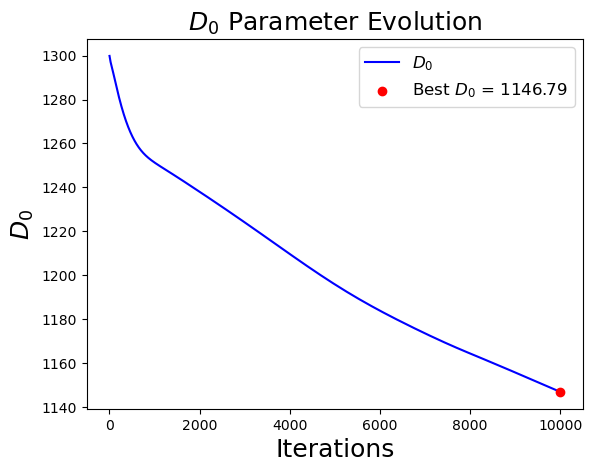

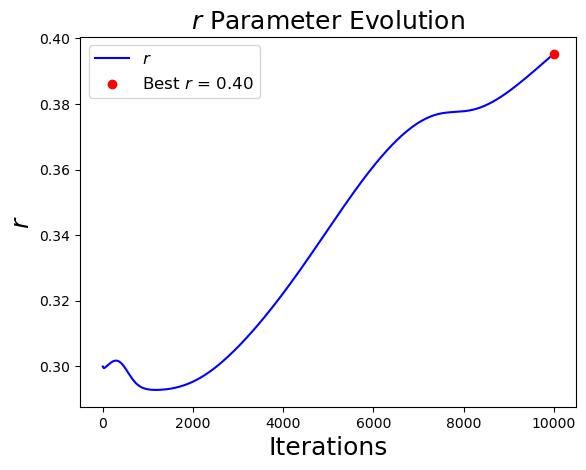

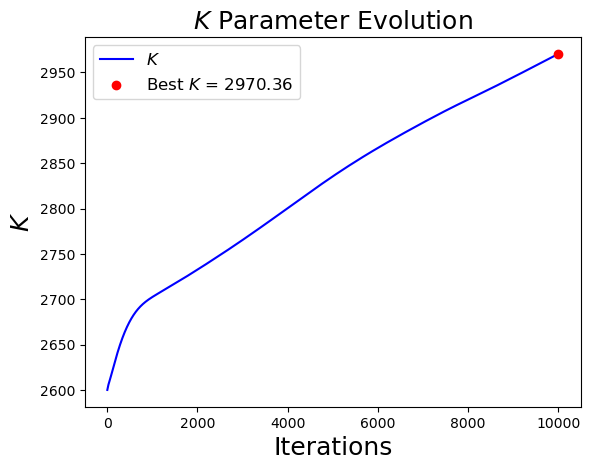

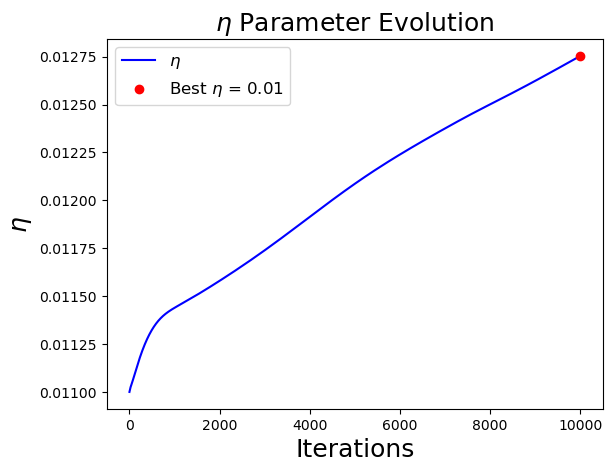

In [ ]:

# Create a range for iterations
iterations = list(range(1, len(D_0_history) + 1))

# Plot D_0
plt.plot(iterations, D_0_history, label="$D_0$", color="blue")
plt.scatter(iterations[D_0_history.index(best_params["D_0"])], best_params["D_0"],
            color="red", label=f"Best $D_0$ = {best_params['D_0']:.2f}", zorder=5)
plt.title("$D_0$ Parameter Evolution", fontsize=18)
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("$D_0$", fontsize=18)
plt.legend(fontsize = 'large')
plt.savefig("D0_1_Porous.pdf", format='pdf')
plt.show()

# Plot r
plt.plot(iterations, r_history, label="$r$", color="blue")
plt.scatter(iterations[r_history.index(best_params["r"])], best_params["r"],
            color="red", label=f"Best $r$ = {best_params['r']:.2f}", zorder=5)
plt.title("$r$ Parameter Evolution", fontsize=18)
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("$r$", fontsize=18)
plt.legend(fontsize = 'large')
plt.savefig("r_1_Porous.pdf", format='pdf')
plt.show()


# Plot K
plt.plot(iterations, K_history, label="$K$", color="blue")
plt.scatter(iterations[K_history.index(best_params["K"])], best_params["K"],
            color="red", label=f"Best $K$ = {best_params['K']:.2f}", zorder=5)
plt.title("$K$ Parameter Evolution", fontsize=18)
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("$K$", fontsize=18)
plt.legend(fontsize = 'large')
plt.savefig("K_1_Porous.pdf", format='pdf')
plt.show()

# Plot gama
plt.plot(iterations, eta_history, label="$\\eta$", color="blue")
plt.scatter(iterations[eta_history.index(best_params["eta"])], best_params["eta"],
            color="red", label=f"Best $\\eta$ = {best_params['eta']:.2f}", zorder=5)
plt.title("$\\eta$ Parameter Evolution", fontsize=18)
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("$\\eta$", fontsize=18)
plt.legend(fontsize = 'large')
plt.savefig("eta_1_Porous.pdf", format='pdf')
plt.show()